# Nonlinear Elasticity in a multipatch domain


In [1]:
%pylab inline
import scipy
import itertools

from pyiga import bspline, assemble, vform, geometry, vis, solvers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# assemble matrix
from scipy.sparse import coo_matrix, block_diag, bmat
from scipy.sparse import bsr_matrix

# line search
from scipy.optimize import line_search

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
p = 3  # spline degree 
x_el= 40
y_el= 15
n_el = (x_el, y_el)  #(40,15)# number of elements in y/x direction, isotropic material
# displacement space: degree p,   continuity p-1
multi= 1
kvs_u = tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=multi) for n in n_el) # or : mult=2
m_u = tuple(kv.numdofs for kv in kvs_u)

In [3]:
# rubber, Lamé-coeff.
Mu = 3 # [MPa]
Lam = 0.28416 #  [MPa] (under ass. ny=0.48, almost incompressible)
# compressible: Lam = 0


In [4]:
# define geometry
# realistic model of an artery: r_inner= 4mm, r_outer= 7mm (preprint)
# human carotid artery: r_i= 3.1 mm, r_o= 4mm (Holzapfel)
r_out = 4
r_in = 3.1

geos = [
 
    geometry.quarter_annulus(r1=r_in, r2=r_out),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(3*pi/2),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(pi),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(pi/2)
]

patches_u = [(kvs_u, g) for g in geos]

# Here we auto-detect the interfaces between the patches.
MP_u = assemble.Multipatch(patches_u, automatch=True)

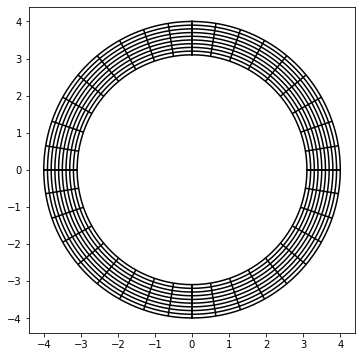

In [5]:
figsize(8,6)
for g in geos:
    vis.plot_geo(g)
axis('scaled');

In [6]:
class multipatch_block_handler:
    
    # Takes array of multi-patch objects
    def __init__( self, multi_patches ):
        self.multi_patches = multi_patches
        self.numpatches = multi_patches[0].numpatches
        for multi_patch in multi_patches:
            if multi_patch.numpatches != self.numpatches:
                print("Inconsistent numbers of patches")

    def patch_to_global(self, p):
        first = True
        for multi_patch in self.multi_patches:
            if first:
                X = multi_patch.patch_to_global(p)
                first = False
            else:
                X = scipy.sparse.block_diag((X,multi_patch.patch_to_global(p)))
        return X
    
    def compute_dirichlet_bcs(self, data):
        first = True
        p = 0
        offset = 0
        for multi_patch in self.multi_patches:
            data_p = []
            for item in data:
                #print(item[3])
                if len(item)<4 or p in item[3]:
                    data_p.append( (item[0], item[1], lambda *x : item[2](*x)[p]) )
            if len(data_p)>0:
                bcs_p = multi_patch.compute_dirichlet_bcs(data_p)
                #print('bcs_p', bcs_p)
                if first:
                    bcs = list(bcs_p)
                    first = False
                else:
                    #Indices need offset
                    bcs[0] = numpy.concatenate((bcs[0],bcs_p[0]+offset))
                    #Values are kept as-is
                    bcs[1] = numpy.concatenate((bcs[1],bcs_p[1]))
            offset += multi_patch.numdofs
            p += 1
        return tuple(bcs)
    
    def compute_local_offset_for_component(self, p, c):
        offset = 0
        for cc in range(c):
            dim = 1
            kvs, geo = self.multi_patches[cc].patches[p]
            for kv in kvs:
                dim *= kv.numdofs
            offset += dim
        return offset
    

In [7]:
# Multipatch objects for all variables
MP_block = multipatch_block_handler( [MP_u, MP_u] )

In [8]:
# source term f 
def f(x, y): return (0.0, 0.0)

# Neumann BC
def gN(x, y): 
    return (x/r_in*loading_value, y/r_in*loading_value)  #inner  pressure, normalized vector

# Robin BC
def g_robin(x, y): 
    return ( 1-(x/r_out+ y/r_out)**2) # scalar value
    

In [9]:
# define Dirichlet boundary function 
def g_zero(x, y): return (0.0, 0.0)

# set up Dirichlet boundary conditions
bc = MP_block.compute_dirichlet_bcs([
    (1, 'right', g_zero ) 
])


In [10]:
def plot_grid(x, y, ax=None, **kwargs):
    """Plot a grid over a geometry"""
    ax = ax or plt.gca()
    segs1 = np.stack((x, y), axis=2)
    segs2 = segs1.transpose(1, 0, 2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

In [78]:
#split the solution into its components (displacement in x- and y- direction)
# visualization per patch
def get_defplot(u, patches_u, kvs_u):
    """Split solution vector into displacement components."""
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
   
    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]

    # evaluate displacement (and "pressure") over a grid in the parameter domain
    # grid variables
    ref = y_el # take number of elements in y-dir  #OR: set manually!
    xgrid = linspace(0, 1, ref)
    xygrid = (xgrid, xgrid)
    len_xgrid= len(xgrid)
    vrange= None
   
    figsize(10,10)
    fig, ax = plt.subplots()
    
    # visualization per patch
    for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches_u): #u_funcs 
        dis1 = u1_func.grid_eval(xygrid) #x-value
        dis2 = u2_func.grid_eval(xygrid) #y-value
        dis = np.stack((dis1,dis2), axis=-1)
        G = geo.grid_eval(xygrid)
        plot_grid(G[..., 0], G[..., 1], ax=ax, color="lightgrey")
        plot_grid(G[..., 0] + dis[..., 0], G[..., 1] + dis[..., 1], ax=ax, color="black")
        
        C = np.sqrt(np.power(dis[..., 0], 2) + np.power(dis[..., 1], 2))
        #print('C=', C)
        
        if vrange is None:
            vrange = (C.min(), C.max())
            
        plt.pcolormesh(G[..., 0] + dis[..., 0], G[..., 1] + dis[..., 1], C, shading='gouraud', cmap='viridis', 
                                    vmin=vrange[0], vmax=vrange[1])
        #vis.plot_deformation(dis, ref, geo, ax, vmin=0.0, vmax=1.5e-3)
    colorbar();
    axis('equal')


In [79]:
# Compute solution of nonlinear elasticity problem

In [80]:
#split the solution into its components (displacement in x- and y- direction) and convert to BSpline function
def get_components(u, kvs_u):
    """Split solution vector into displacement components."""
    N = np.prod(tuple(kv.numdofs for kv in kvs_u))
    u1 = u[:N].reshape(m_u)          
    u2 = u[N:].reshape(m_u)    
    U = np.stack((u1,u2), axis=-1)
    return bspline.BSplineFunc(kvs_u, U)

In [81]:
def get_components_u(u, kvs_u):
    """Split solution vector into displacement components."""
    N = np.prod(tuple(kv.numdofs for kv in kvs_u))
    u1 = u[:N].reshape(m_u)          
    u2 = u[N:].reshape(m_u)    
    return np.stack((u1,u2), axis=-1)

In [82]:
# nonlinear variational form
def apply_nl(u_p, kvs_ux, geo_ux, X):
    dis = get_components(X.T @ u_p, kvs_ux)
    
    z_lam = Lam* assemble.assemble('div(dis)*div(v) * dx+ 1/2 *tr( grad(dis).T *grad(dis)) *div(v)*dx + inner(div(dis)*grad(dis), grad(v))*dx + inner(1/2 * tr(grad(dis).T *grad(dis))*grad(dis), grad(v)) *dx'
                             , kvs_ux, bfuns=[('v',2)], geo=geo_ux, dis=dis)
    z_mu = Mu* assemble.assemble('inner(grad(dis).T +grad(dis) + grad(dis).T *grad(dis), grad(v))*dx + inner(grad(dis)*(grad(dis).T +grad(dis) + grad(dis).T*grad(dis)), grad(v)) *dx'
                                    , kvs_ux, bfuns=[('v',2)], geo=geo_ux, dis=dis)
    return (z_lam + z_mu).ravel()  # vector z

# linearized variational form
def linearized(u_p, kvs_ux, geo_ux, X):
    dis = get_components(X.T @ u_p, kvs_ux)
    
    A_lin_lam = Lam* assemble.assemble('(inner( (div(dis) + 1/2 *tr( grad(dis).T *grad(dis) )) * grad(u), grad(v)) + div(u)*div(v) + tr( grad(dis).T *grad(u) ) * div(v) + inner( (div(u) + tr(grad(dis).T *grad(u)) ) * grad(dis), grad(v)) ) * dx'
                              , kvs_ux, bfuns=[('u',2), ('v',2)], geo=geo_ux, dis=dis) #matrix A_lam
    
    A_lin_mu = 2*Mu * assemble.assemble('(inner(1/2 * grad(u)*(grad(dis)+ grad(dis).T + grad(dis).T *grad(dis)) + (1/2) * (grad(u)+grad(u).T + grad(dis).T *grad(u) + grad(u).T *grad(dis)) + 1/2 * grad(dis)*(grad(u)+grad(u).T +grad(dis).T * grad(u)+ grad(u).T * grad(dis)), grad(v))) * dx'
                              , kvs_ux, bfuns=[('u',2), ('v',2)], geo=geo_ux, dis=dis) #matrix A_mu
    
    return A_lin_lam + A_lin_mu # matrix A


In [83]:
def rotate_normal(nv): # rotate
    nv_rot= []
    nx= nv[..., 0]
    ny= nv[..., 1]
    nv_rot= np.stack((ny,-nx), axis=-1)
    return nv_rot

In [103]:
# assemble matrix A and rhs b for nonlinear elasticity problem # Neumann force + Robin matrix
def ass_nonlinsystem_RN(u):
    first = True
    firstR = True
    
    for p in range(MP_block.numpatches):
        X = MP_block.patch_to_global(p)
        
        # All the geometries are supposed to be equal; also kvs_ux and kvs_uy are equal
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p] #kvs_uy, geo_uy
        
        # The whole patch-local stiffness matrix
        A_p = linearized(u, kvs_ux, geo_ux, X) # take linearized variatonal form
        
        ### assemble mass matrix ####
        M_x = assemble.mass(kvs_ux, geo_ux)
        M_p = scipy.sparse.bmat(
            [[M_x, None,],
            [None, M_x]], format='csr')
        
        # The patch-local Neumann boundary data, right-hand side
        b_p = assemble.inner_products(kvs_ux, f, f_physical=True, geo=geo_ux).ravel() - apply_nl(u, kvs_ux, geo_ux, X)  # for arbitrary rhs
        
        # Robin-Data
        alpha= 1. # set factor
        for item in robin_data:
            if item[0]==p:
                alpha= item[3] # set alpha, penalization
                #AR_u = alpha * assemble.assemble('u * v * ds', kvs_ux, bfuns=None, geo=geo_ux, g=item[2],
                                           #  format='csr', layout='blocked',boundary=item[1])
                AR_u = alpha*assemble.assemble('u * v *g* ds', kvs_ux, bfuns=None, geo=geo_ux, g=item[2],
                                                      format='csr', layout='blocked',boundary=item[1])

                bdofs_R = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(2): #x and y 
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    if firstR:
                        AR = X.tocsr()[:,bdofs_R+offset] @ AR_u @ X.tocsr()[:,bdofs_R+offset].T
                        firstR = False
                    else:
                        AR += X.tocsr()[:,bdofs_R+offset] @ AR_u @ X.tocsr()[:,bdofs_R+offset].T
                     

        uu = get_components_u(X.T @ u, kvs_ux)
        for item in neu_data:
            if item[0]==p:
                # use neumann function
                N_en1 = assemble.assemble('inner(g,v)*ds', kvs_ux, bfuns=[('v',2)], geo=geo_ux, g=item[2], boundary=item[1], layout='packed') #first attempt 
                #print(shape(N_en1))
                #print('N_en1=', N_en1)
                
                ## implemented normal vector
                #nv = assemble.assemble('inner(v, n) * ds', kvs_ux, bfuns=[('v', 2)], geo=geo_ux, boundary=item[1], layout='packed')
                #nv_r = rotate_normal(nv)
                #n_tilde = nv- rotate_normal(uu * nv_r)
                #N_en= -n_tilde*loading_value
                #print(shape(N_en))
                #print('N_en3=', N_en)
  
                # normal vector with loading
                N_en = assemble.assemble('inner(n,v)*ds', kvs_ux, bfuns=[('v',2)], geo=geo_ux, boundary=item[1], layout='packed')
                N_en *= -loading_value
                #print('N_en2=', N_en2)
        
                bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(2): #x and y 
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    for i in range(len(bdofs)):
                        b_p[bdofs[i]+offset] += N_en[i, 0, c] # (43,1,2)
                        
        
        if first:
            A = X @ A_p @ X.T
            M = X @ M_p @ X.T
            b = X @ b_p 
            first = False
        else:
            A += X @ A_p @ X.T
            M += X @ M_p @ X.T
            b += X @ b_p 
           
    return A+AR, M, b-AR@u

In [127]:
# elasticity problem
#linear problem = linearized problem (for development point x_0=(0...0) )
def grad_J(x): #nonlin function (rhs) # u
    
    u_p = x
    first = True
    firstR = True
    
    for p in range(MP_block.numpatches): # go through each patch
        X = MP_block.patch_to_global(p)
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]
        uu = get_components_u(X.T @ u, kvs_ux)

        b_p = apply_nl(u_p, kvs_ux, geo_ux, X) #non-linear form a(u,v)
        
        dis = get_components(X.T @ u_p, kvs_ux)
        # Robin-Data
        alpha = 1. # set factor
        for item in robin_data:
            if item[0]==p:
                if item[3]:
                    alpha= item[3] # set alpha, penalization
                AR_u = alpha* assemble.assemble('u * v *g* ds', kvs_ux, bfuns=None, geo=geo_ux, g=item[2],
                                                      format='csr', layout='blocked',boundary=item[1])

                bdofs_R = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(2): #x and y 
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    if firstR:
                        AR = X.tocsr()[:,bdofs_R+offset] @ AR_u @ X.tocsr()[:,bdofs_R+offset].T
                        firstR = False
                    else:
                        AR += X.tocsr()[:,bdofs_R+offset] @ AR_u @ X.tocsr()[:,bdofs_R+offset].T
                             

        for item in neu_data:
            if item[0]==p:
                # normal vector with loading
                #nv = -assemble.assemble('inner(v, n) * ds', kvs_ux, bfuns=[('v', 2)], geo=geo_ux, boundary=item[1], layout='packed')
                #nv_r = rotate_normal(nv)
                #n_tilde = nv - rotate_normal(uu * nv_r)
                #N_en = -n_tilde*loading_value ## adapted normal
                
                #N_en  = -assemble.assemble('inner(g,v)*ds', kvs_ux, bfuns=[('v',2)], geo=geo_ux, g=item[2], boundary=item[1], layout='packed') # first attempt
                
                N_en = -assemble.assemble('inner(n,v)*ds', kvs_ux, bfuns=[('v',2)], geo=geo_ux, boundary=item[1], layout='packed')
                N_en *= -loading_value
                
                bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(2):
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    for i in range(len(bdofs)):
                        b_p[bdofs[i]+offset] += N_en[i, 0, c]
                                        
                        
        if first:
            grad_b = X @ b_p
            first = False
        else:
            grad_b += X @ b_p
            
    return grad_b + AR @ u


# define constant spline functions for integration
kvs_j = tuple(bspline.make_knots(0, 0.0, 1.0, n, mult=multi) for n in n_el) # constant basis vector for integration

def J(x): #energy functional
    u_p = x
    j = 0
    j_R = 0
    j_N = 0
    for p in range(MP_block.numpatches): # go through each patch
        X = MP_block.patch_to_global(p)
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]

        dis = get_components(X.T @ u_p, kvs_ux)
        j_lam = Lam/8 * assemble.assemble('tr( grad(dis).T *grad(dis) +grad(dis).T +grad(dis))**2 *v*dx'
                             , kvs_j, bfuns=[('v',1)], geo=geo_ux, dis=dis).ravel()
        j_mu = Mu/4 * assemble.assemble('tr((grad(dis).T *grad(dis) +grad(dis).T +grad(dis))*(grad(dis).T *grad(dis) +grad(dis).T +grad(dis))) *v*dx'
                                    , kvs_j, bfuns=[('v',1)], geo=geo_ux, dis=dis).ravel()
        j_p = sum(j_lam + j_mu)
    
    # Robin-Data
        alpha = 1. # set factor
        for item in robin_data:
            if item[0]==p:
                if item[3]:
                    alpha= item[3]
                R_p = alpha* assemble.assemble('u*v*g *ds', kvs_j, bfuns=[('u',1),('v',1)], geo=geo_ux, g=item[2], boundary=item[1], layout='packed', dis=dis) #first attempt 
                j_R += R_p.sum()
        
        for item in neu_data:
            if item[0]==p:
                N_e = -assemble.assemble('inner(n, dis) *v * ds', kvs_j, bfuns=[('v',1)], geo=geo_ux, boundary=item[1], dis=dis)
                N_e *= loading_value
                #N_e  = assemble.assemble('inner(g,dis) *v *ds', kvs_j, bfuns=[('v',1)], geo=geo_ux, g=item[2], boundary=item[1], dis=dis) 
                j_N += N_e.sum()

        j += (j_p + j_R - j_N)
        
    return j


In [105]:
def Wolfe_LineSearch(f, f_grad, xk, pk):
    # Wolfe-Powell_Line search
    print('Start line search')
    
    mu1 = 0.01
    sigma = 0.9
    tau = 0.5 # 0.1
    tau1 = 0.3
    tau2 = 0.9
    gsi1 = 1
    gsi2 = 10
    
    def phi(alpha):
        return f(xk + alpha * pk)

    def derphi(alpha):
        #print('f_grad=', f_grad(xk + alpha * pk))
        return np.dot(f_grad(xk + alpha * pk), pk)
    
    alpha_L = 0
    alpha_R = None
    phi_L = phi(0)
    derphi0 = derphi(0)
    derphi_L = derphi0
    
    #alphainf= True
    alpha =1 
    phi_min = -1.e2
    
    eps0 = 1.e-6
    max_iter = 10
    n_iter = 0
    #alpha_int= None
    
    
    if derphi0 >= 0:
        print('  no descent direction: {}'.format(derphi_L))
        return None
    
    while n_iter < max_iter:
        print("  {}. alpha between {} and {}".format(n_iter,alpha_L,alpha_R))
        n_iter +=1
        if alpha > 1: # alpha too big # alpha in(0,1)?
            print('alpha >1')
            alpha_R = alpha
            alpha= alpha_L + tau1*(alpha_R - alpha_L)
        else:
            phi_hat= phi(alpha)
            #print('     alpha = {} gives {}'.format(alpha,math.sqrt(phi_hat)))
            if phi_hat < phi_min: # function unbounded to the bottom
                return alpha 

            if phi_hat > phi(0) + mu1*alpha*derphi(0): #alpha too big # 
                print('     alpha too big')
               # alphainf= False
                alpha_R = alpha
                delta = alpha_R - alpha_L
               # print('  delta=', delta)

                ## interpolation
                c = (phi_hat - phi_L - derphi_L*delta)/delta**2
                alpha_tilde = alpha_L - derphi_L/(2*c)
                alpha = min(max(alpha_L+ tau*delta, alpha_tilde), alpha_R - tau*delta)
                #print('alpha_int=', alpha)
                #alpha_int = alpha

            else: # alpha not too big
                derphi_hat = derphi(alpha)
                #print('     derphi_hat = {} and sigma*derphi(0) = {}'.format(derphi_hat,sigma*derphi(0)))
                if derphi_hat < sigma*derphi0: # alpha too small
                    print('     alpha too small')
                    if alpha_R != None and .6 * alpha_R < alpha:
                        print('     Interval small enough, so dont bother.')
                        return alpha
                    if alpha_R == None: # alpha_R == inf
                        if derphi_L/derphi_hat > (1+ gsi2)/gsi2:
                            alpha_tilde = alpha + (alpha - alpha_L)*max(derphi_hat/(derphi_L -derphi_hat), gsi1)
                        else:
                            alpha_tilde = alpha + gsi2*(alpha - alpha_L)
                    else: # alpha_R < inf
                        if derphi_L/derphi_hat > 1 + (alpha-alpha_L)/(tau2*(alpha_R -alpha)):
                            alpha_tilde = alpha + max((alpha-alpha_L)*derphi_hat/(derphi_L - derphi_hat), tau1*(alpha_R- alpha))
                        else:
                            alpha_tilde = alpha + tau2*(alpha_R - alpha)
                    ## update
                    alpha_L = alpha
                    phi_L = phi_hat
                    derphi_L = derphi_hat
                    alpha = alpha_tilde
                else:
                    print('     alpha neither too big, nor too small')
                    return alpha

    return alpha


In [106]:
def Wolfe_LineSearch_st(f, f_grad, xk, pk, alpha_R=None):
    # Wolfe-Powell_Line search
    print('Start Wolfe line search')
    
    mu1 = 0.01
    sigma = 0.9
    tau = 0.1
    tau1 = 0.3
    tau2 = 0.9
    gsi1 = 1
    gsi2 = 10
    
    def phi(alpha):
        return f(xk + alpha * pk)

    def derphi(alpha):
        return np.dot(f_grad(xk + alpha * pk), pk)
    
    alpha_L = 0
    #alpha_R = 1 #None
    phi0 = phi(0)
    phi_L = phi0
    derphi0 = derphi(0)
    derphi_L = derphi0
    alpha = 1 
    phi_min = -1.e2
    
    eps0 = 1.e-6
    max_iter = 20
    n_iter = 0
    
    if derphi0 >= 0:
        print('  no descent direction: {}'.format(derphi_L))
        return None
    
    while n_iter < max_iter:
        print("  {}. alpha between {} and {}".format(n_iter,alpha_L,alpha_R))
        n_iter +=1

        phi_hat = phi(alpha)
        #if phi_hat < phi_min: # function unbounded to the bottom
        #    return alpha 

        print('     alpha = {} gives {}'.format(alpha,math.sqrt(phi_hat)))
        
        if phi_hat > phi0 + mu1*alpha*derphi0: # alpha too big
            print('     alpha too big')
            alpha_R = alpha
            delta = alpha_R - alpha_L
            ## interpolation
            c = (phi_hat - phi_L - derphi_L*delta)/delta**2
            alpha_tilde = alpha_L - derphi_L/(2*c)
            alpha = min(max(alpha_L + tau*delta, alpha_tilde), alpha_R - tau*delta)

        else: # alpha not too big
            derphi_hat = derphi(alpha)
            #print('     derphi_hat = {} and sigma*derphi(0) = {}'.format(derphi_hat,sigma*derphi(0)))
            if derphi_hat < sigma*derphi0: # alpha too small
                print('     alpha too small')
                if alpha_R != None and .6 * alpha_R < alpha:
                    print('     Interval small enough, so dont bother.')
                    return alpha
                if alpha_R == None: # alpha_R == inf
                    if derphi_L/derphi_hat > (1+ gsi2)/gsi2:
                        alpha_tilde = alpha + (alpha - alpha_L)*max(derphi_hat/(derphi_L -derphi_hat), gsi1)
                    else:
                        alpha_tilde = alpha + gsi2*(alpha - alpha_L)
                else: # alpha_R < inf
                    if derphi_L/derphi_hat > 1 + (alpha-alpha_L)/(tau2*(alpha_R -alpha)):
                        alpha_tilde = alpha + max((alpha-alpha_L)*derphi_hat/(derphi_L - derphi_hat), tau1*(alpha_R- alpha))
                    else:
                        alpha_tilde = alpha + tau2*(alpha_R - alpha)
                ## update
                alpha_L = alpha
                phi_L = phi_hat
                derphi_L = derphi_hat
                alpha = alpha_tilde
            else:
                print('     alpha neither too big, nor too small')
                return alpha

    return alpha

In [107]:
def Armijo(f, f_grad, xk, pk):
    # Amijo_Line search
    print('Start line search')
    
    mu1 = 0.01
    tau = 0.1 # 0.5
    
    def phi(alpha):
        return f(xk + alpha * pk)

    def derphi(alpha):
        return np.dot(f_grad(xk + alpha * pk), pk)
    
    alpha_L = 0
    alpha_R = None
    phi_L = phi(0)
    derphi0 = derphi(0)
    derphi_L = derphi(0)
    alphainf= True
    alpha =1 
    phi_min = -1.e2
    eps0 = 1.e-6
    max_iter = 5
    n_iter = 0
    
    if derphi(0) >= 0:
        print('  no descent direction: {}'.format(derphi_L))
        return None
    

    while n_iter < max_iter:
        print("  {}. alpha between {} and {}".format(n_iter,alpha_L,alpha_R))
        n_iter +=1
        phi_hat= phi(alpha)
        derphi_hat = derphi(alpha)

        if phi_hat > phi(0) + mu1*alpha*derphi(0): #alpha too big #  

            alphainf= False
            alpha_R = alpha

            delta = alpha_R - alpha_L
            # print('  delta=', delta)
            ## interpolation
            c = (phi_hat - phi_L - derphi_L*delta)/delta**2
            alpha_tilde = alpha_L - derphi_L/(2*c)
            alpha = min(max(alpha_L+ tau*delta, alpha_tilde), alpha_R - tau*delta)
            print('alpha_int=', alpha)
            
        else:
            return alpha

In [108]:
def make_solver_orig(B, symmetric=False, spd=False):
    """Return a :class:`LinearOperator` that acts as a linear solver for the
    (dense or sparse) square matrix `B`.

    If `B` is symmetric, passing ``symmetric=True`` may try to take advantage of this.
    If `B` is symmetric and positive definite, pass ``spd=True``.
    """
    if spd:
        symmetric = True
# Gauß'sche Eliminationsverfahren - LU Zerlegung (auch LR für left-right)
    if scipy.sparse.issparse(B):
        print('use SuperLU')
            # use SuperLU (unless scipy uses UMFPACK?) -- really slow!
        spLU = scipy.sparse.linalg.splu(B.tocsc(), permc_spec='NATURAL')
        M= scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype, matvec=spLU.solve, matmat=spLU.solve)
        return M
# Cholesky Zerlegung: Matrix muss symmetrisch und positiv definit sein!                  
    else:
        if symmetric:
            print('use Cholesky')
            chol = scipy.linalg.cho_factor(B, check_finite=False)
            solve = lambda x: scipy.linalg.cho_solve(chol, x, check_finite=False)
            return scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype,
                    matvec=solve, matmat=solve)
        else:
            print('Matrix is not symmetric')
            LU = scipy.linalg.lu_factor(B, check_finite=False)
            solve = lambda x: scipy.linalg.lu_solve(LU, x, check_finite=False)
            return scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype,
                    matvec=solve, matmat=solve)

In [109]:
def make_solver(matrix):
    B= matrix.todense()
    """Return a :class:`LinearOperator` that acts as a linear solver for the
    (dense or sparse) square matrix `B`.

    If `B` is symmetric, passing ``symmetric=True`` may try to take advantage of this.
    If `B` is symmetric and positive definite, pass ``spd=True``.
    """
    
    chol = scipy.linalg.cho_factor(B, check_finite=False) # for s. p.d matrix
    solve = lambda x: scipy.linalg.cho_solve(chol, x, check_finite=False)
    return scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype, matvec=solve, matmat=solve)
       

In [110]:
def solve(matrix, vector):
    try:
        return make_solver(matrix).dot(vector)
    # cholesky --> takes spd matrix
    except LinAlgError:
        print('use Gradient direction') # matrix not positive definite
        return vector
        #return 10000*vector
        

In [111]:
def get_defplotPP(u, patches_u, kvs_u):
    """Split solution vector into displacement components."""
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
    
    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]

    # evaluate displacement (and "pressure") over a grid in the parameter domain
    # grid variables
    ref = y_el # take number of elements in y-dir  #OR: set manually!
    xgrid = linspace(0, 1, ref)
    xygrid = (xgrid, xgrid)
    len_xgrid= len(xgrid)
    vrange= None
   
    figsize(7,7)
    fig, ax = plt.subplots()
    ###
    
    max_xval_i = 0
    max_yval_i = 0
    max_rad_i = 0
    max_rad_o = 0
    idx_ri = 0
    idx_ro = 0
    count=0
    # visualization per patch
    for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches_u): #u_funcs 
        print('\n patch:', count)
        dis1 = u1_func.grid_eval(xygrid) #x-value
        dis2 = u2_func.grid_eval(xygrid) #y-value
        dis = np.stack((dis1,dis2), axis=-1)
       
        G = geo.grid_eval(xygrid)
        x_val_i=[]
        y_val_i=[]
        x_val_o=[]
        y_val_o=[]
        
        i= 0
        
    
        radius_inner = np.sqrt( (G[i,0, 0]+dis1[i, 0])**2 + (G[i,0, 1]+dis2[i,0])**2)
        radius_outer = np.sqrt((G[i,y_el-1, 0]+dis1[i, y_el-1])**2 + (G[i,y_el-1, 1]+dis2[i,y_el-1])**2)
        print('inner radius_{}= {}'.format(i, radius_inner))
        print('outer radius_{}= {}'.format(i, radius_outer))
        
        print (' ratio:', radius_inner/radius_outer) # with respect to max. inner radius coord.
        
        plot(G[i, 0, 0] + dis1[i, 0], G[i, 0, 1] + dis2[i, 0], 'ro') # inner radius
        plot(G[i, y_el-1, 0] + dis1[i, y_el-1], G[i, y_el-1, 1] + dis2[i, y_el-1], 'bo') # outer radius

        
        i= 8
        radius_inner = np.sqrt( (G[i,0, 0]+dis1[i, 0])**2 + (G[i,0, 1]+dis2[i,0])**2)
        radius_outer = np.sqrt((G[i,y_el-1, 0]+dis1[i, y_el-1])**2 + (G[i,y_el-1, 1]+dis2[i,y_el-1])**2)
        print('inner radius_{}= {}'.format(i, radius_inner))
        print('outer radius_{}= {}'.format(i, radius_outer))
        
        print (' ratio:', radius_inner/radius_outer, '\t') # with respect to max. inner radius coord.
        
        plot(G[i, 0, 0] + dis1[i, 0], G[i, 0, 1] + dis2[i, 0], 'mo') # inner radius 
        plot(G[i, y_el-1, 0] + dis1[i, y_el-1], G[i, y_el-1, 1] + dis2[i, y_el-1], 'co') # outer radius

        

        count+=1
       
        C = np.sqrt(np.power(dis[..., 0], 2) + np.power(dis[..., 1], 2))
        if vrange is None:
            vrange = (C.min(), C.max())
            
        plt.pcolormesh(G[..., 0] + dis[..., 0], G[..., 1] + dis[..., 1], C, shading='gouraud', cmap='viridis', 
                                    vmin=vrange[0], vmax=vrange[1])
        #vis.plot_deformation(dis, ref, geo, ax, vmin=0.0, vmax=1.5e-3)
    colorbar();
    axis('equal')


In [112]:
#incremental loading
maxload = 4e-1 #1e0 #9e-2 #9e-2# 8e-1 # 6e-2 # 4e-1
nsteps= 3
loading= np.linspace(maxload/nsteps, maxload, nsteps)

In [113]:
alpha = 1e0
robin_data = [(1, 'right', g_robin, alpha)] # instead of Dirichlet-bdc, outer bd fixed

r0= 0.00038511977074889495
use SuperLU
residual =  0.00020741960169076918


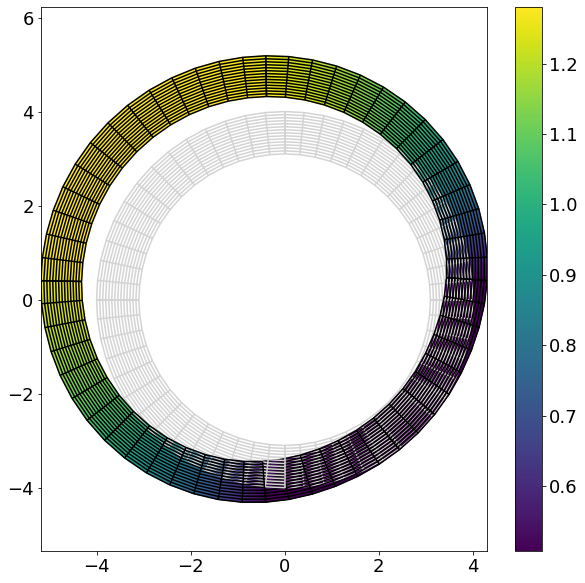

In [114]:
# solve linearized system #Robin instead of Dirichlet, + Neumann force (inner pressure)
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]

#initial value
u= np.zeros(dd)
solution= []

# set Neumann boundary force (via incremental loading) 

### Linear elasticity for largest loading
loading_value = loading[-1] # take last loading value
neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] # set neumann

### first iteration ###
A, M, b = ass_nonlinsystem_RN(u)
r0= np.transpose(b).dot(M.dot(b)) #L2-norm
print('r0=', r0)

u_d = make_solver_orig(A).dot(b) 
u += u_d

A, M, b = ass_nonlinsystem_RN(u)
r= np.transpose(b).dot(M.dot(b)) #L2-norm
print('residual = ', r)

###-----------------###--------------------###
solution = [u]
# norm of delta u in first step
normed_du0= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
###----------------###---------------------###

# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u)


 patch: 0
inner radius_0= 3.4726621478995456
outer radius_0= 4.325872702134428
 ratio: 0.8027656815204247
inner radius_8= 4.064414653555935
outer radius_8= 4.923618262303699
 ratio: 0.8254934556307878 	

 patch: 1
inner radius_0= 3.472662147901637
outer radius_0= 4.325872702136364
 ratio: 0.8027656815205491
inner radius_8= 3.1496925742520987
outer radius_8= 4.015499802849881
 ratio: 0.7843836954036701 	

 patch: 2
inner radius_0= 4.3373005764935755
outer radius_0= 5.201753266146227
 ratio: 0.8338151301257143
inner radius_8= 3.9300887924849195
outer radius_8= 4.786751950228475
 ratio: 0.8210345623397789 	

 patch: 3
inner radius_0= 4.337300576489307
outer radius_0= 5.201753266141948
 ratio: 0.8338151301255796
inner radius_8= 4.446679858392892
outer radius_8= 5.312784489535371
 ratio: 0.8369772700457827 	


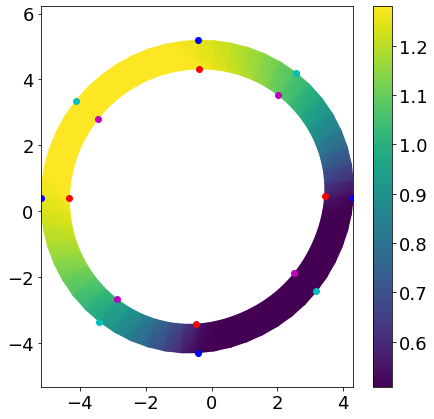

In [115]:
get_defplotPP(u, patches_u, kvs_u)

In [116]:
loading

array([0.13333333, 0.26666667, 0.4       ])

In [117]:
u

array([0.34332401, 0.34184724, 0.33901478, ..., 0.4029028 , 0.40369042,
       0.40408642])

Norm of rhs for max loading: 0.6092618308159109
Tolerance:                   6.092618308159109e-05
 
 
 1. loading: 0.13333333333333333 

1
Residual = 0.20308727693863693
use SuperLU
residual = 0.04112507657854736
2
use SuperLU
residual = 0.00029807318422395455
3
use SuperLU
residual = 4.423184374458158e-05
u=  [0.09986508 0.09935603 0.09838414 ... 0.1498745  0.14993442 0.14996561]
 
 
 2. loading: 0.2666666666666667 

1
Residual = 0.20307924874831668
use SuperLU
residual = 0.05274904433829055
2
use SuperLU
residual = 0.037448260190260076
3
use SuperLU
residual = 0.0003117800550222505
4
use SuperLU
residual = 1.6942633463508798e-06
u=  [0.19359287 0.19253371 0.19052859 ... 0.28305905 0.28359008 0.28385831]
 
 
 3. loading: 0.4 

1
Residual = 0.20308698313291287
use SuperLU
residual = 0.04390449109140717
2
use SuperLU
residual = 0.0006551311106668932
3
use SuperLU
residual = 1.47483993287866e-06
u=  [0.27278925 0.27113025 0.26801238 ... 0.4445454  0.44554052 0.44604469]


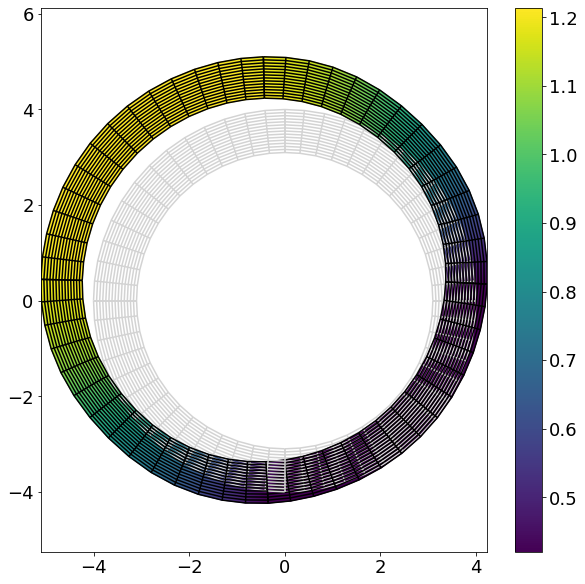

In [118]:
# solve linearized variational problem

#initial value
u= np.zeros(dd)

epsilon= 1e-4# 1e-5

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


### Linear elasticity for largest loading
loading_value = loading[-1] # take last loading value
neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] # set neumann data

A, M, b = ass_nonlinsystem_RN(u)
#r0= np.transpose(b).dot(M.dot(b)) #L2-norm
r0 = np.linalg.norm(b)

print("Norm of rhs for max loading: {}".format(r0))
print("Tolerance:                   {}".format(r0*epsilon))
###

# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    loading_value = loading[t]
    neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] 

    count = 0
    while True:
        count+=1
        print(count)

        # Assemble matrices and rhs in every iteration step
        if count == 1:
            A, M, b = ass_nonlinsystem_RN(u)
            #r= np.transpose(b).dot(M.dot(b)) #L2-norm
            r = np.linalg.norm(b)
            print('Residual =',r)

        # # solve system # #
        u_d = make_solver_orig(A).dot(b)           
        u += u_d            

        # compute new non-linear residuum
        A, M, b = ass_nonlinsystem_RN(u)
        #r = np.transpose(b).dot(M.dot(b)) #L2-norm
        r= np.linalg.norm(b)
        print('residual =', r)

        #----------------------------------------------------#
        ud_array.append(u_d)
        #normed_du= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = alpha * normed_du # times alpha
        stepsizes.append(stepsize_du)
        #---------------------------------------------------#

        if r < epsilon * r0: # break condition
            break
        elif count == 30:
            break
    #
    ud_array.append(u_d) 
    print('u= ' , u)
    solutions.append(np.array(u))
    iter_counts.append(count)
        
# print deformation plot
get_defplot(u, patches_u, kvs_u)

In [119]:
solutions

[array([0.09986508, 0.09935603, 0.09838414, ..., 0.1498745 , 0.14993442,
        0.14996561]),
 array([0.19359287, 0.19253371, 0.19052859, ..., 0.28305905, 0.28359008,
        0.28385831]),
 array([0.27278925, 0.27113025, 0.26801238, ..., 0.4445454 , 0.44554052,
        0.44604469])]

Norm of rhs for max loading: 0.00038511977074889495
Tolerance:                   3.8511977074889495e-08
 
 
 1. loading: 0.13333333333333333 

Residual= 4.2791085638766095e-05
1
use SuperLU
0.041244442054350766: Matrix is positive definite; use Newton direction.
grad_k*p_k= -0.6724276632410102
Start line search
  0. alpha between 0 and None
alpha= 1
residual = 2.5017104941192778e-06
2
use SuperLU
0.0016912719235913781: Matrix is positive definite; use Newton direction.
grad_k*p_k= -0.004138820328107635
Start line search
  0. alpha between 0 and None
alpha_int= 0.1
  1. alpha between 0 and 1
alpha_int= 0.010000000000000002
  2. alpha between 0 and 0.1
alpha_int= 0.0010000000000000002
  3. alpha between 0 and 0.010000000000000002
alpha_int= 0.00010000000000000003
  4. alpha between 0 and 0.0010000000000000002
alpha_int= 1.0000000000000004e-05
alpha= None
Use simple line search:
  alpha 1.0 gives residual 1.7551249371556707e-10
  alpha 2.0 gives residual 2.3942089291083444e-06
alpha = 1.0

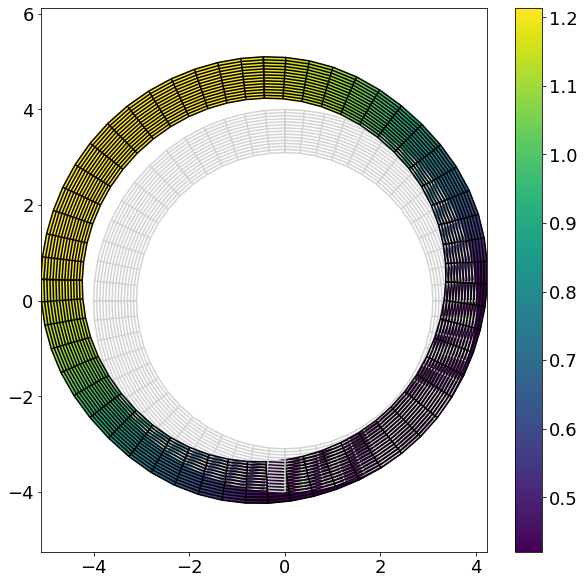

In [128]:
 #solve nonlinear system
#initial value

u= np.zeros(dd)

epsilon= 1e-4# 1e-5

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


### Linear elasticity for largest loading
loading_value = loading[-1] # take last loading value
neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] # set neumann data


A, M, b = ass_nonlinsystem_RN(u)
r0= np.transpose(b).dot(M.dot(b)) #L2-norm

print("Norm of rhs for max loading: {}".format(r0))
print("Tolerance:                   {}".format(r0*epsilon))
###



# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    loading_value = loading[t]
    neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] 
    
    # first residuum
    A, M, b = ass_nonlinsystem_RN(u)
    r= np.transpose(b).dot(M.dot(b)) #L2-norm
    print('Residual=', r)

    count= 0
    rejected = False
    
    while True:
        count+=1
        print(count)

        # Assemble matrices and rhs in every iteration step
        A, M, b = ass_nonlinsystem_RN(u)
        u_d = make_solver_orig(A).dot(b) 
        

        # check if matrix is positive definite in a particular direction u_d
        sp = b.dot(A @ u_d) # For the residual,...
        #if LS.b.dot(u_d) <= 0:
        if sp <= 0 or rejected: 
            print('{}: Matrix is not positive definite (or rejected); use gradient direction anyway!'.format(sp))
            u_d = b
            rejected = False
        else:
            print('{}: Matrix is positive definite; use Newton direction.'.format(sp))
        
        print( 'grad_k*p_k=',  np.dot(grad_J(u), u_d))

        # # do Wolfe-Powell line search # # 
        #alpha= Wolfe_LineSearch(J, grad_J, u, u_d) 
        
        # Line Search 
        alpha= Armijo(J, grad_J, u, u_d) 
        print('alpha=', alpha)
        
        if alpha != None:
            unew = u + alpha * u_d
            # compute new non-linear residuum
            A, M, b = ass_nonlinsystem_RN(unew)
            rnew = np.transpose(b).dot(M.dot(b)) #L2-norm
            if rnew > r:
                print("New residual would be {}. Reject this alpha!".format(rnew))
                alpha = None
        
        if alpha == None:           
            print('Use simple line search:')
            #u += 0.5 * u_d # alpha=0.5 (ignore line search)
            # Lets try to do gradient search
            alpha = 1.
            rnew = r+1 ####
            while rnew > r and alpha > 1e-4:
                unew = u + alpha * u_d
                # compute new non-linear residuum
                A, M, b = ass_nonlinsystem_RN(unew)
                rnew = np.transpose(b).dot(M.dot(b)) #L2-norm
                #rnew = np.linalg.norm(LS.b) # compute residuum
                print('  alpha {} gives residual {}'.format(alpha,rnew))
                alpha /= 2
            if rnew > r:
                alpha = None
                print("alpha =", alpha)
                if rejected:
                    break # No way to continue !?
                else:
                    alpha = 0
                    rejected = True
            alpha *= 2 # double alpha
            if alpha >= 1:
                alpha = 2.
                rlast = rnew
                while alpha < 10000 and rnew <= rlast:
                    unew = u + alpha * u_d
                    # compute new non-linear residuum
                    A, M, b = ass_nonlinsystem_RN(unew)
                    rlast = rnew
                    rnew = np.transpose(b).dot(M.dot(b)) #L2-norm
                    print('  alpha {} gives residual {}'.format(alpha,rnew))
                    alpha *= 2 # double alpha
                alpha /= 4 # quater alpha

            print("alpha =", alpha)            
            
        u += alpha * u_d            

            
        # compute new non-linear residuum
        A, M, b = ass_nonlinsystem_RN(u)
        r = np.transpose(b).dot(M.dot(b)) #L2-norm
        print('residual =', r)


        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        stepsize_du = alpha * normed_du # times alpha
        stepsizes.append(stepsize_du)
        #---------------------------------------------------#

        if r < epsilon* r0: # break condition # r < epsilon* r1:
            break
        elif count == 30:
            break
  
    ud_array.append(u_d) 
    solutions.append(np.array(u))
    iter_counts.append(count)
        
# print deformation plot
get_defplot(u, patches_u, kvs_u)

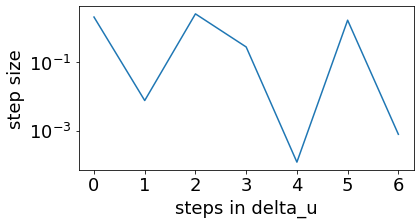

In [129]:
# plot history of step sizes
figsize(6,3)
fig, ax = plt.subplots()
yscale('log')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(stepsizes);
xlabel('steps in delta_u'); ylabel('step size');

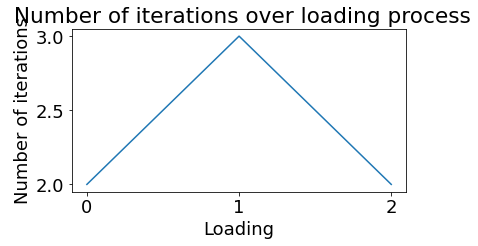

In [130]:
figsize(6,3)
fig, ax= plt.subplots()

s_cts= shape(iter_counts)[0]
plot(range(s_cts), iter_counts)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title(' Number of iterations over loading process');
xlabel('Loading'); ylabel('Number of iterations');

In [131]:
"""Visualization functions."""
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection


def animate_field(fields, patches_u, kvs_u, vrange=None, res=(50,50),cmap=None, interval=50, progress=True):
    """Animate a sequence of scalar fields over a geometry."""
    fields = list(fields)
    
    figsize(7,7)
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_xlim(left=-5.5, right=5)
    ax.set_ylim(bottom=-5, top=5.5)
    
    
    ar= np.linspace(1,3, s_sol)
    factor = ar[0]
    C = None

    if np.isscalar(res):
        res = (res, res)

    # first solution
    #u= LS.complete(fields[0])
    u= fields[0]
    
    #Split solution vector into displacement components
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs::]
    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]

    # evaluate displacement (and "pressure") over a grid in the parameter domain
    # visualization per patch
    for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches_u): #u_funcs 
        grd = tuple(np.linspace(s[0], s[1], r) for (s, r) in zip(geo.support, res))
        XY = geo.grid_eval(grd)
        dis1 = u1_func.grid_eval(grd) #x-value
        dis2 = u2_func.grid_eval(grd) #y-value
        dis = np.stack((dis1,dis2), axis=-1)
        if C is None:
            C = np.sqrt(np.power(dis[..., 0], 2) + np.power(dis[..., 1], 2))
        if vrange is None:
            #vrange = (0.0, 1.5e-3)
            vrange = (C.min(), C.max())
        #vis.plot_grid(XY[..., 0] + dis[..., 0], XY[..., 1] + dis[..., 1], ax=ax, color="black")
        quadmesh = plt.pcolormesh(XY[..., 0] + factor* dis[..., 0], XY[..., 1] + factor*dis[..., 1], C, shading='gouraud', cmap='viridis',
                                    vmin=vrange[0], vmax=vrange[1], axes=ax)
        
   
    fig.colorbar(quadmesh, ax=ax);
    tqdm = vis.utils.progress_bar(progress)
    pbar = tqdm(total=len(fields))
    
    def anim_func(i):
        plt.cla()
        ax.set_xlim(left=-5.5, right=5)
        ax.set_ylim(bottom=-5, top=5.5)
        #factor = ar[i] # choose factor for deformation plot
        #u = LS.complete(fields[i])
        u= fields[i]
        u1 = u[:MP_u.numdofs] 
        u2 = u[MP_u.numdofs:]
        
        vrange= None

    # restrict solution to each individual patch - BSpline functions
        u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
               for p in range(len(patches_u))]
        u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
               for p in range(len(patches_u))]

    # visualization per patch
        for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches_u): #u_funcs 
            grd = tuple(np.linspace(s[0], s[1], r) for (s, r) in zip(geo.support, res))
            XY = geo.grid_eval(grd)
            dis1 = u1_func.grid_eval(grd) #x-value
            dis2 = u2_func.grid_eval(grd) #y-value
            dis = np.stack((dis1,dis2), axis=-1)
            C = np.sqrt(np.power(dis[..., 0], 2) + np.power(dis[..., 1], 2))
            if vrange is None:
                #vrange = (0.0, 1.5e-3)
                vrange = (C.min(), C.max())
            quadmesh = plt.pcolormesh(XY[..., 0] + factor*dis[..., 0], XY[..., 1] + factor*dis[..., 1], C, shading='gouraud', cmap='viridis', 
                                      vmin=vrange[0], vmax=vrange[1], axes=ax)
        
            #quadmesh.set_array(C.ravel())
            pbar.update()
            if i == len(u) - 1:
                pbar.close()
  
    return animation.FuncAnimation(plt.gcf(), anim_func, frames=len(fields), interval=interval, repeat=False)


16it [00:00, 21.30it/s]              


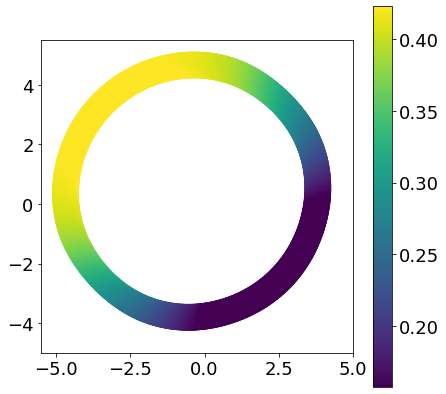

In [132]:
from IPython.display import HTML

figsize(14, 4)
s_sol= shape(solutions)[0]
fields = [solutions[tt] for tt in range(s_sol)]
HTML(animate_field(fields, patches_u, kvs_u, res=(50,70), interval=335, progress=True).to_html5_video())

In [133]:
plt.clf()

<Figure size 504x504 with 0 Axes>

In [134]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection

plt.rcParams['animation.html'] = 'html5'
plt.rcParams['font.size'] = 18

fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')
res=(50,70)
#vrange=(0.0, 1.5e-3)

s_sol= shape(solutions)[0]
ims = []
ar= np.linspace(1,3, s_sol)
factor = 1


#fields = list(ud_array)
fields = list(solutions)

for tt in range(s_sol):
    #u = LS.complete(fields[tt])
    u = fields[tt]
    #factor = ar[tt] # choose factor for deformation plot
    vrange = None
    ims_q = []
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:]

    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
            for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
            for p in range(len(patches_u))]
    plt.ioff()
    
    # visualization per patch
    for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches_u): #u_funcs 
        im_q=[]
        grd = tuple(np.linspace(s[0], s[1], r) for (s, r) in zip(geo.support, res))
        XY = geo.grid_eval(grd)
        dis1 = u1_func.grid_eval(grd) #x-value
        dis2 = u2_func.grid_eval(grd) #y-value
        dis = np.stack((dis1,dis2), axis=-1)
        C = np.sqrt(np.power(dis[..., 0], 2) + np.power(dis[..., 1], 2))
        if vrange is None:
            #vrange = (0.0, 1.5e-3)
            vrange = (C.min(), C.max())
        im_q = plt.pcolormesh(XY[..., 0] + factor*dis[..., 0], XY[..., 1] + factor*dis[..., 1], C, shading='gouraud', cmap='viridis', 
                                    vmin=vrange[0], vmax=vrange[1], axes=ax) # shading for smoothing
        
        im_q.set_array(C.ravel()) 
        ims_q.append(im_q) 
    
    ims.append(ims_q)
    #print(shape(ims))
#print(ims[0])
    
#fig.colorbar(im_q, ax=ax);
colorbar();
ani = animation.ArtistAnimation(fig, ims, blit=True, repeat= False) # repeat_delay=2000



#ani.to_html5_video()


Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'))
#ani.save("rtest.mp4", writer=writer )
vid = ani.to_html5_video()

plt.close()



In [135]:
ani

In [43]:
#vid

In [ ]:
 #solve nonlinear system
#initial value

u= np.zeros(dd)

epsilon= 1e-4# 1e-5

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


### Linear elasticity for largest loading
loading_value = loading[-1] # take last loading value
neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] # set neumann data


A, M, b = ass_nonlinsystem_RN(u)
r0= np.transpose(b).dot(M.dot(b)) #L2-norm

print("Norm of rhs for max loading: {}".format(r0))
print("Tolerance:                   {}".format(r0*epsilon))
###



# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    loading_value = loading[t]
    neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] 
    
    # first residuum
    A, M, b = ass_nonlinsystem_RN(u)
    r= np.transpose(b).dot(M.dot(b)) #L2-norm
    print('Residual=', r)

    count= 0
    rejected = False
    
    while True:
        count+=1
        print(count)

        # Assemble matrices and rhs in every iteration step
        A, M, b = ass_nonlinsystem_RN(u)
        u_d = make_solver_orig(A).dot(b) 
        

        # check if matrix is positive definite in a particular direction u_d
        sp = b.dot(A @ u_d) # For the residual,...
        #if LS.b.dot(u_d) <= 0:
        if sp <= 0 or rejected: 
            print('{}: Matrix is not positive definite (or rejected); use gradient direction anyway!'.format(sp))
            u_d = b
            rejected = False
        else:
            print('{}: Matrix is positive definite; use Newton direction.'.format(sp))
        
        print( 'grad_k*p_k=',  np.dot(grad_J(u), u_d))

        # # do Wolfe-Powell line search # # 
        alpha= Wolfe_LineSearch(J, grad_J, u, u_d)  
        print('alpha=', alpha)
        
        if alpha != None:
            unew = u + alpha * u_d
            # compute new non-linear residuum
            A, M, b = ass_nonlinsystem_RN(unew)
            rnew = np.transpose(b).dot(M.dot(b)) #L2-norm
            if rnew > r:
                print("New residual would be {}. Reject this alpha!".format(rnew))
                alpha = None
        
        if alpha == None:           
            print('Use simple line search:')
            #u += 0.5 * u_d # alpha=0.5 (ignore line search)
            # Lets try to do gradient search
            alpha = 1.
            rnew = r+1 ####
            while rnew > r and alpha > 1e-4:
                unew = u + alpha * u_d
                # compute new non-linear residuum
                A, M, b = ass_nonlinsystem_RN(unew)
                rnew = np.transpose(b).dot(M.dot(b)) #L2-norm
                #rnew = np.linalg.norm(LS.b) # compute residuum
                print('  alpha {} gives residual {}'.format(alpha,rnew))
                alpha /= 2
            if rnew > r:
                alpha = None
                print("alpha =", alpha)
                if rejected:
                    break # No way to continue !?
                else:
                    alpha = 0
                    rejected = True
            alpha *= 2 # double alpha
            if alpha >= 1:
                alpha = 2.
                rlast = rnew
                while alpha < 10000 and rnew <= rlast:
                    unew = u + alpha * u_d
                    # compute new non-linear residuum
                    A, M, b = ass_nonlinsystem_RN(unew)
                    rlast = rnew
                    rnew = np.transpose(b).dot(M.dot(b)) #L2-norm
                    print('  alpha {} gives residual {}'.format(alpha,rnew))
                    alpha *= 2 # double alpha
                alpha /= 4 # quater alpha

            print("alpha =", alpha)            
            
        u += alpha * u_d            

            
        # compute new non-linear residuum
        A, M, b = ass_nonlinsystem_RN(u)
        r = np.transpose(b).dot(M.dot(b)) #L2-norm
        print('residual =', r)


        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        stepsize_du = alpha * normed_du # times alpha
        stepsizes.append(stepsize_du)
        #---------------------------------------------------#

        if r < epsilon* r0: # break condition # r < epsilon* r1:
            break
        elif count == 30:
            break
  
    ud_array.append(u_d) 
    solutions.append(np.array(u))
    iter_counts.append(count)
        
# print deformation plot
get_defplot(u, patches_u, kvs_u)